In [4]:
import subprocess
import os
import math
from functions.basefunctions import *
from collections import defaultdict
import numpy as np
import time 

kbT_RNA = 0.6163207755

In [35]:
import pickle

with open('../data/fRNAhammingdistance.pkl', 'rb') as f:
    fRNAhammingdistance = pickle.load(f)

with open('../data/fRNAprob2.pkl', 'rb') as f:
    fRNAprob2 = pickle.load(f)

with open('../data/fRNAprob1.pkl', 'rb') as f:
    fRNAprob1 = pickle.load(f)

with open('../data/fRNAfolds.pkl', 'rb') as f:
    fRNAfolds = pickle.load(f)
with open('../data/merged_dict.pkl', 'rb') as f:
    merged_dict= pickle.load(f)

In [6]:
len(fRNAhammingdistance), len(fRNAprob2)

(311016, 311016)

# Only left of the line from specific point, just to test
point1= (0.15382552893408447, 0.18181818181818182)
point0 = (0.24487580716620733, 0.8095238095238095)

These results are given in in data files 'site_scanning_probs_pval_seq_left'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


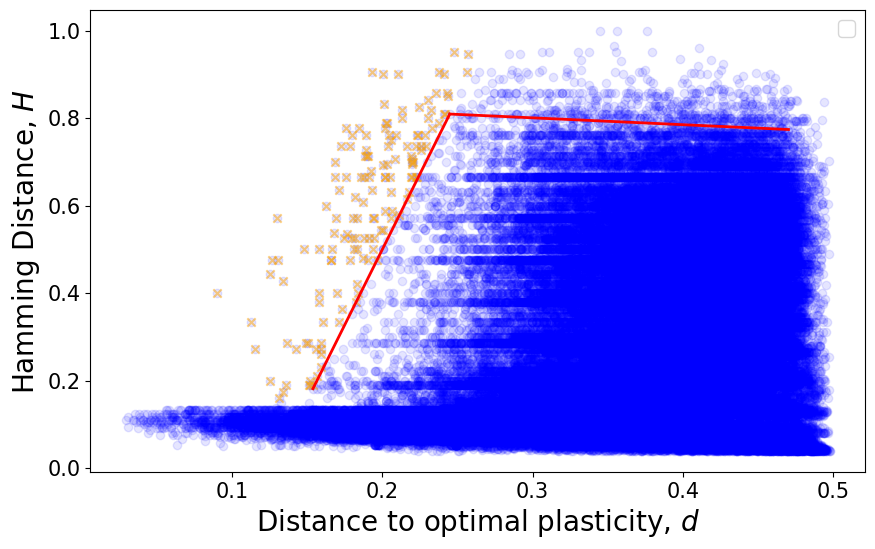

In [7]:
from matplotlib import pyplot as plt 
import numpy as np

# Calculate the distance from the diagonal (0.5, 0.5)
diagonal_distances = {}
for x, y,key1,key2 in zip(fRNAprob1.values(), fRNAprob2.values(), fRNAprob1.keys(), fRNAprob2.keys()):
    if key1 == key2:
        distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)/np.sqrt(2)
        diagonal_distances[key1] = distance

selected_names = []
selected_hamming_values =[]
selected_min_distances = []
for name in fRNAhammingdistance.keys():
    if '.' * len(name[1]) not in fRNAfolds[name]:
        selected_names.append(name)
        selected_hamming_values.append(fRNAhammingdistance[name])
        selected_min_distances.append(diagonal_distances[name])
selected_names = np.array(selected_names)
selected_hamming_values = np.array(selected_hamming_values)
selected_min_distances = np.array(selected_min_distances)
# Define the coordinates of the two points
#point0 = (0.30688980382826875, 0.7777777777777778)
#point1 = (0.20333026388667144, 0.16)
point2 = (0.4702129756344944,0.7741935483870968)

point1= (0.15382552893408447, 0.18181818181818182)
point0 = (0.24487580716620733, 0.8095238095238095)

# Calculate the slope (m) and y-intercept (b) of the line
m = (point1[1] - point0[1]) / (point1[0] - point0[0])
b = point0[1] - m * point0[0]

m1= (point2[1] - point0[1]) / (point2[0] - point0[0])
b1 = point0[1] - m1 * point0[0]

# Define a function to determine if a point is to the left of the line
def is_left_of_line(x, y, m, b):
    return y > m * x + b
def is_hamming_greater_than_small(h,h0=0.15):
    return h > h0

left_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m, b) & is_hamming_greater_than_small(selected_hamming_values)
# Filter points that are to the left of the second line
top_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m1, b1)

left_names = selected_names[left_mask]
left_min_distances = selected_min_distances[left_mask]
left_hamming_values = selected_hamming_values[left_mask]
combined_mask = left_mask & top_mask
topminuscombined_mask = top_mask & ~combined_mask
topminuscombined_min_distances = selected_min_distances[topminuscombined_mask]
topminuscombined_hamming_values = selected_hamming_values[topminuscombined_mask]
topminuscombined_names = selected_names[topminuscombined_mask]
joined_names = np.concatenate((topminuscombined_names, left_names))
joined_min_distances = np.concatenate((topminuscombined_min_distances, left_min_distances))
joined_hamming_values = np.concatenate((topminuscombined_hamming_values, left_hamming_values))

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(selected_min_distances, selected_hamming_values, c='blue', marker='o', alpha=0.1)
plt.scatter(left_min_distances, left_hamming_values, c='orange', marker='x', alpha=0.5)
#plt.scatter(left_min_distances, left_hamming_values, c='purple', marker='x', alpha=0.5, label='Left of Line')
plt.plot([point0[0], point1[0]], [point0[1], point1[1]], color='red', linestyle='-', linewidth=2)
plt.plot([point0[0], point2[0]], [point0[1], point2[1]], color='red', linestyle='-', linewidth=2)


# Add labels and title
plt.ylabel(r'Hamming Distance, $H$', fontsize=20)
plt.xlabel(r'Distance to optimal plasticity, $d$', fontsize=20)
#plt.title('Selected fRNA sequences for analysis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
plt.legend(fontsize=15)
# Show the plot
plt.show()

In [18]:
import glob
import pandas as pd
import re
import numpy as np
from scipy.stats import norm
from collections import defaultdict
import pickle
# Path to the data folder
data_folder = '../data/'

# Pattern to match the files
file_pattern = data_folder + 'site_scanning_probs_pval_seq_left*_ssize100000.pkl'

# List to store p-values from all files
nameandrankdist_hammingandprobs_pvals_left = defaultdict(dict)


files = glob.glob(file_pattern)

# Loop through each file and extract probs2
for file in files:
    match = re.search(r'site_scanning_probs_pval_seq_left(\d+)_ssize100000', file)
    
    if match:
        seq_number = int(match.group(1))
        # Read the file into a DataFrame
        with open(file, 'rb') as f:
            data = pickle.load(f)
        
        # Extract probs2 and append to the list
        probs2 = list(data['probs2'])
        observed_value = fRNAprob2[tuple(left_names[seq_number])]  # Replace with your specific value
        
        mean = np.mean(probs2)
        std_dev = np.std(probs2)

        # Compute the z-score for the observed value
        z_score = (observed_value - mean) / std_dev

        # One-tailed p-value (upper-tail)
        p_value_upper = 1 - norm.cdf(z_score)
        if p_value_upper < 0.05:
            print(seq_number, tuple(left_names[seq_number]), p_value_upper)
            nameandrankdist_hammingandprobs_pvals_left[tuple(left_names[seq_number])][(fRNAhammingdistance[tuple(left_names[seq_number])],fRNAprob1[tuple(left_names[seq_number])],fRNAprob2[tuple(left_names[seq_number])])] = p_value_upper
    


82 ('FR447807||Fly small RNA', 'CTGGAGCTGGAGCTGCAGCTG') 0.016133759043367557
68 ('FR442549||Fly small RNA', 'CGGAGGCGAATGCCAGACGC') 0.015760617870453797
20 ('FR329328|DQ689919|Piwi-interacting RNA (piRNA)', 'TGCAACAGCCTGAACAAAGGCAATTG') 0.008194209769770255
29 ('FR412251||Fly small RNA', 'AAGGAGCATCGTCCACCGGTG') 0.019506409763084487


72 ('FR443912||Fly small RNA', 'CGTGTCACCGGAGGCATGAAGGTGAA') 0.04598591664532048
1 ('FR017024||Putative conserved noncoding region (EvoFold)', 'GATGCCACCGCCTGGGTGGCCTC') 0.02231064216437051
77 ('FR447579||Fly small RNA', 'CTGCTGCGGATGGGGGCAGTAC') 0.026898799451784194
90 ('FR456139||Fly small RNA', 'GCAGAGCTGCAGCGATGCGGA') 0.01801179231016159
44 ('FR422481||Fly small RNA', 'AGTCAAACGGCAAAACGG') 0.031105406237797117
81 ('FR447806||Fly small RNA', 'CTGGAGCTGGAGCTGCAGCTA') 0.009943055800997191
16 ('FR258706||mature micro RNA (miRNA) miR-27a-3p', 'TTCACAGTGGCTAAGTTCCGCC') 0.010812287512418584
6 ('FR091786|DQ765545|Piwi-interacting RNA (piRNA)', 'TAGAAAGGACAAGGGTCCAATGATCCAGAC') 0.028536853903184167
93 ('FR457213||Fly small RNA', 'GCCGAGAACGTGCTTGATATT') 0.04760926337461968
89 ('FR454945||Fly small RNA', 'GATGGTCTCATCGACGGT') 0.04357384506470785
25 ('FR409389||Fly small RNA', 'AAAGTGACCGCCGAAAAGGTA') 0.014001111164685387
130 ('FR490430||Fly small RNA', 'TGGAGCATTTGATTGCAAATG') 0.038063738706

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


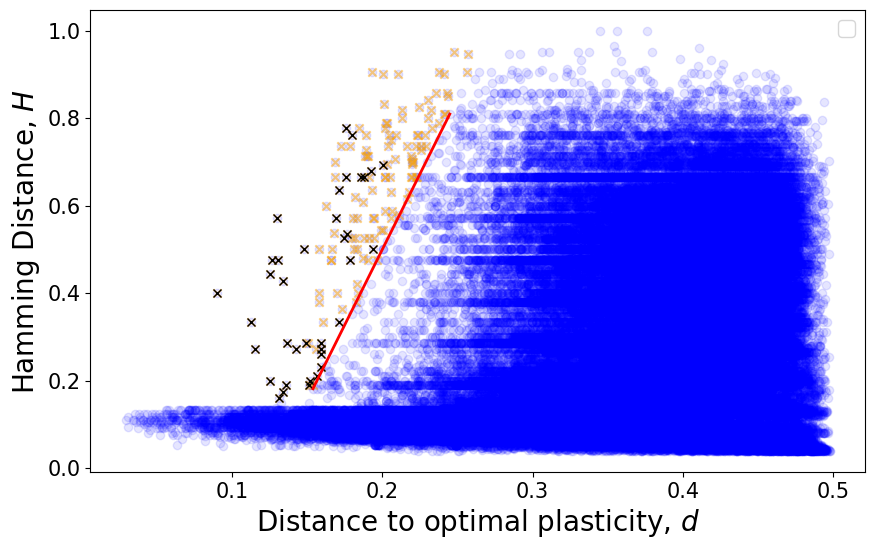

In [9]:
from matplotlib import pyplot as plt 
import numpy as np

# Calculate the distance from the diagonal (0.5, 0.5)
diagonal_distances = {}
for x, y,key1,key2 in zip(fRNAprob1.values(), fRNAprob2.values(), fRNAprob1.keys(), fRNAprob2.keys()):
    if key1 == key2:
        distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)/np.sqrt(2)
        diagonal_distances[key1] = distance

selected_names = []
selected_hamming_values =[]
selected_min_distances = []
for name in fRNAhammingdistance.keys():
    if '.' * len(name[1]) not in fRNAfolds[name]:
        selected_names.append(name)
        selected_hamming_values.append(fRNAhammingdistance[name])
        selected_min_distances.append(diagonal_distances[name])
selected_names = np.array(selected_names)
selected_hamming_values = np.array(selected_hamming_values)
selected_min_distances = np.array(selected_min_distances)
# Define the coordinates of the two points
#point0 = (0.30688980382826875, 0.7777777777777778)
#point1 = (0.20333026388667144, 0.16)
point2 = (0.4702129756344944,0.7741935483870968)

point1= (0.15382552893408447, 0.18181818181818182)
point0 = (0.24487580716620733, 0.8095238095238095)

# Calculate the slope (m) and y-intercept (b) of the line
m = (point1[1] - point0[1]) / (point1[0] - point0[0])
b = point0[1] - m * point0[0]

m1= (point2[1] - point0[1]) / (point2[0] - point0[0])
b1 = point0[1] - m1 * point0[0]

# Define a function to determine if a point is to the left of the line
def is_left_of_line(x, y, m, b):
    return y > m * x + b
def is_hamming_greater_than_small(h,h0=0.15):
    return h > h0

left_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m, b) & is_hamming_greater_than_small(selected_hamming_values)
# Filter points that are to the left of the second line
top_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m1, b1)

left_names = selected_names[left_mask]
left_min_distances = selected_min_distances[left_mask]
left_hamming_values = selected_hamming_values[left_mask]
combined_mask = left_mask & top_mask
topminuscombined_mask = top_mask & ~combined_mask
topminuscombined_min_distances = selected_min_distances[topminuscombined_mask]
topminuscombined_hamming_values = selected_hamming_values[topminuscombined_mask]
topminuscombined_names = selected_names[topminuscombined_mask]
joined_names = np.concatenate((topminuscombined_names, left_names))
joined_min_distances = np.concatenate((topminuscombined_min_distances, left_min_distances))
joined_hamming_values = np.concatenate((topminuscombined_hamming_values, left_hamming_values))

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(selected_min_distances, selected_hamming_values, c='blue', marker='o', alpha=0.1)
plt.scatter(left_min_distances, left_hamming_values, c='orange', marker='x', alpha=0.5)
for name in nameandrankdist_hammingandprobs_pvals_left.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')
#plt.scatter(left_min_distances, left_hamming_values, c='purple', marker='x', alpha=0.5, label='Left of Line')
plt.plot([point0[0], point1[0]], [point0[1], point1[1]], color='red', linestyle='-', linewidth=2)
#plt.plot([point0[0], point2[0]], [point0[1], point2[1]], color='red', linestyle='-', linewidth=2)


# Add labels and title
plt.ylabel(r'Hamming Distance, $H$', fontsize=20)
plt.xlabel(r'Distance to optimal plasticity, $d$', fontsize=20)
#plt.title('Selected fRNA sequences for analysis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
plt.legend(fontsize=15)
# Show the plot
plt.show()

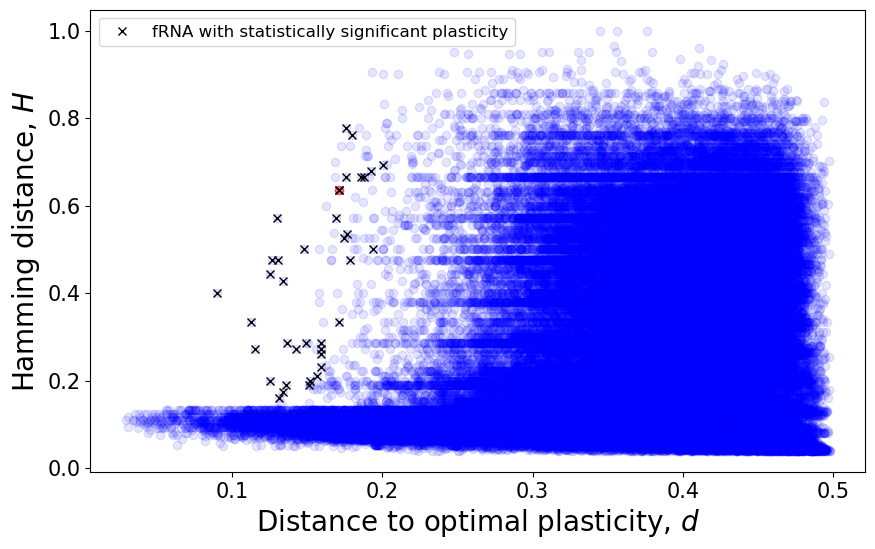

In [19]:
from matplotlib import pyplot as plt 
import numpy as np

# Calculate the distance from the diagonal (0.5, 0.5)
diagonal_distances = {}
for x, y,key1,key2 in zip(fRNAprob1.values(), fRNAprob2.values(), fRNAprob1.keys(), fRNAprob2.keys()):
    if key1 == key2:
        distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)/np.sqrt(2)
        diagonal_distances[key1] = distance

selected_names = []
selected_hamming_values =[]
selected_min_distances = []
for name in fRNAhammingdistance.keys():
    if '.' * len(name[1]) not in fRNAfolds[name]:
        selected_names.append(name)
        selected_hamming_values.append(fRNAhammingdistance[name])
        selected_min_distances.append(diagonal_distances[name])
selected_names = np.array(selected_names)
selected_hamming_values = np.array(selected_hamming_values)
selected_min_distances = np.array(selected_min_distances)
# Define the coordinates of the two points
#point0 = (0.30688980382826875, 0.7777777777777778)
#point1 = (0.20333026388667144, 0.16)
point2 = (0.4702129756344944,0.7741935483870968)

point1= (0.15382552893408447, 0.18181818181818182)
point0 = (0.24487580716620733, 0.8095238095238095)

# Calculate the slope (m) and y-intercept (b) of the line
m = (point1[1] - point0[1]) / (point1[0] - point0[0])
b = point0[1] - m * point0[0]

m1= (point2[1] - point0[1]) / (point2[0] - point0[0])
b1 = point0[1] - m1 * point0[0]

# Define a function to determine if a point is to the left of the line
def is_left_of_line(x, y, m, b):
    return y > m * x + b
def is_hamming_greater_than_small(h,h0=0.15):
    return h > h0

left_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m, b) & is_hamming_greater_than_small(selected_hamming_values)
# Filter points that are to the left of the second line
top_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m1, b1)

left_names = selected_names[left_mask]
left_min_distances = selected_min_distances[left_mask]
left_hamming_values = selected_hamming_values[left_mask]
combined_mask = left_mask & top_mask
topminuscombined_mask = top_mask & ~combined_mask
topminuscombined_min_distances = selected_min_distances[topminuscombined_mask]
topminuscombined_hamming_values = selected_hamming_values[topminuscombined_mask]
topminuscombined_names = selected_names[topminuscombined_mask]
joined_names = np.concatenate((topminuscombined_names, left_names))
joined_min_distances = np.concatenate((topminuscombined_min_distances, left_min_distances))
joined_hamming_values = np.concatenate((topminuscombined_hamming_values, left_hamming_values))

# Create a scatter plot
name = tuple(left_names[22])

observed_value_distance = diagonal_distances[name]
observed_value_hamming = fRNAhammingdistance[name]
plt.figure(figsize=(10, 6))
plt.scatter(selected_min_distances, selected_hamming_values, c='blue', marker='o', alpha=0.1)
plt.scatter(observed_value_distance, observed_value_hamming, c='red', marker='o', alpha=0.5)
#plt.scatter(left_min_distances, left_hamming_values, c='orange', marker='x', alpha=0.5)
for name in nameandrankdist_hammingandprobs_pvals_left.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')
    if name == tuple(left_names[22]):
        plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black', label='fRNA with statistically significant plasticity')
#plt.scatter(left_min_distances, left_hamming_values, c='purple', marker='x', alpha=0.5, label='Left of Line')
#plt.plot([point0[0], point1[0]], [point0[1], point1[1]], color='red', linestyle='-', linewidth=2)
#plt.plot([point0[0], point2[0]], [point0[1], point2[1]], color='red', linestyle='-', linewidth=2)


# Add labels and title
plt.ylabel(r'Hamming distance, $H$', fontsize=20)
plt.xlabel(r'Distance to optimal plasticity, $d$', fontsize=20)
#plt.title('Selected fRNA sequences for analysis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
plt.legend(fontsize=12)
# Show the plot
plt.show()

('FR336157||Putative conserved noncoding region (EvoFold)', 'GGTGAGAGGCACCACATTTACC')
0.32880174073784496
0.02047407482472763


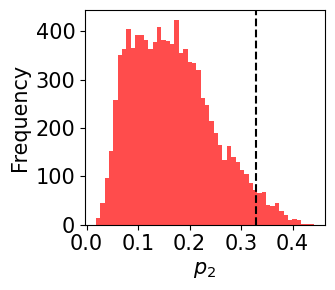

In [20]:
#example for seq 0
import pickle
with open('../data/site_scanning_probs_pval_seq_left22_ssize10000.pkl', 'rb') as f:
    site_scanning_probs_pval_seq_left22_ssize10000 = pickle.load(f)
probs2 = site_scanning_probs_pval_seq_left22_ssize10000['probs2']

# Plot the distributions
name = tuple(left_names[22])
print(name)
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 2)
plt.hist(probs2, bins=50, alpha=0.7, color='red')
plt.xlabel(r'$p_2$',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.title('Site-Scanning Distribution',fontsize=12)

seq_number = 22
# Read the file into a DataFrame
with open('../data/site_scanning_probs_pval_seq_left22_ssize10000.pkl', 'rb') as f:
    data = pickle.load(f)

# Extract probs2 and append to the list
probs2 = list(data['probs2'])
observed_value = fRNAprob2[tuple(left_names[seq_number])]  # Replace with your specific value

mean = np.mean(probs2)
std_dev = np.std(probs2)

# Compute the z-score for the observed value
z_score = (observed_value - mean) / std_dev

# One-tailed p-value (upper-tail)
pval = 1 - norm.cdf(z_score)

observed_value = fRNAprob2[name]
print(observed_value)
print(pval)
plt.axvline(x=observed_value, color='black', linestyle='--',label= r'p-value='+str(np.round(pval,2)))
#plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

# Now get a wider range of points
 can we optimise such that all points are tested?

In [21]:
with open(f"../data/selected_names_left_minus_a.pkl","rb") as f:
        left_names_minus = pickle.load(f)

In [22]:
import glob
import pandas as pd
import re
import numpy as np
from scipy.stats import norm
from collections import defaultdict
import pickle
# Path to the data folder
data_folder = '../data/'

# Pattern to match the files
file_pattern = data_folder + 'site_scanning_probs_pval_seq_left_minus*_ssize10000.pkl'

# List to store p-values from all files
nameandrankdist_hammingandprobs_pvals_left_minus = defaultdict(dict)


files = glob.glob(file_pattern)

# Loop through each file and extract probs2
for file in files:
    match = re.search(r'site_scanning_probs_pval_seq_left_minus(\d+)_ssize10000', file)
    
    if match:
        seq_number = int(match.group(1))
        # Read the file into a DataFrame
        with open(file, 'rb') as f:
            data = pickle.load(f)
        
        # Extract probs2 and append to the list
        probs2 = list(data['probs2'])
        observed_value = fRNAprob2[tuple(left_names_minus[seq_number])]  # Replace with your specific value
        
        mean = np.mean(probs2)
        std_dev = np.std(probs2)

        # Compute the z-score for the observed value
        z_score = (observed_value - mean) / std_dev

        # One-tailed p-value (upper-tail)
        p_value_upper = 1 - norm.cdf(z_score)
        if p_value_upper < 0.05:
            print(seq_number, tuple(left_names_minus[seq_number]), p_value_upper)
            nameandrankdist_hammingandprobs_pvals_left_minus[tuple(left_names_minus[seq_number])][(fRNAhammingdistance[tuple(left_names_minus[seq_number])],fRNAprob1[tuple(left_names_minus[seq_number])],fRNAprob2[tuple(left_names_minus[seq_number])])] = p_value_upper
    


656 ('FR457228||Fly small RNA', 'GCCGAGGGCGCAGCCGAGGA') 0.049036400556988546
680 ('FR459166||Fly small RNA', 'GCTTGATAGCCATTGTTATCCTTTGC') 0.02791640365784831
174 ('FR358593||Putative conserved noncoding region (EvoFold)', 'ACTGCATGATAACATGCTGT') 0.03555157771168149
303 ('FR420090||Fly small RNA', 'AGCAGAGTGGCGCAGT') 0.049596973545311895


436 ('FR434991||Fly small RNA', 'CAGTCTCCTCGGAGGCGTGGGT') 0.028053601598315714
192 ('FR399371||Putative conserved noncoding region (EvoFold)', 'CTCATGGGGGATCTCATGCAG') 0.02789355245181857
346 ('FR423319||Fly small RNA', 'AGTTGCAGCAGAGCGGCAATG') 0.03686749986524396
389 ('FR430704||Fly small RNA', 'CAAAAGCAGTCATCTGAAGGC') 0.04746318376594083
960 ('FR499661||Fly small RNA', 'TTCGAGCCTCACCCGGGGCATGTAC') 0.02826508141252515
42 ('FR085158|DQ570753|Piwi-interacting RNA (piRNA)', 'AGAAGGTGAAAACCAAGGACCTAGGAAA') 0.03925232506746368
236 ('FR412944||Fly small RNA', 'AAGTGGCATCAAGGCCTTCTGG') 0.03851993708588941
235 ('FR412834||Fly small RNA', 'AAGTCGAGCAGCAGGTTCCAC') 0.026626197600870816
759 ('FR462912||Fly small RNA', 'GTAGCCTGCGCCCTGGGAGGCACC') 0.02721693113536572
883 ('FR483378||Fly small RNA', 'TCTCGGCCTTATGGCTAAG') 0.017193429698503016
953 ('FR499290||Fly small RNA', 'TTCCGCACCAGCTCGCTTTCC') 0.033075789680109824
723 ('FR460808||Fly small RNA', 'GGCTGCCCAGAAGGGAAAGAG') 0.0322450963076657
905 (

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


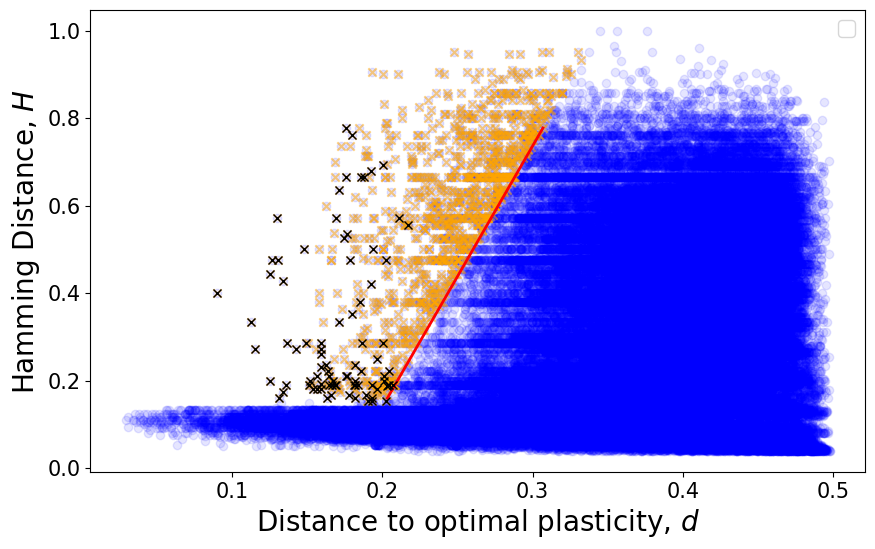

In [23]:
from matplotlib import pyplot as plt 
import numpy as np

diagonal_distances = {}
for x, y,key1,key2 in zip(fRNAprob1.values(), fRNAprob2.values(), fRNAprob1.keys(), fRNAprob2.keys()):
    if key1 == key2:
        distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)/np.sqrt(2)
        diagonal_distances[key1] = distance

selected_names = []
selected_hamming_values =[]
selected_min_distances = []
for name in fRNAhammingdistance.keys():
    if '.' * len(name[1]) not in fRNAfolds[name]:
        selected_names.append(name)
        selected_hamming_values.append(fRNAhammingdistance[name])
        selected_min_distances.append(diagonal_distances[name])
selected_names = np.array(selected_names)
selected_hamming_values = np.array(selected_hamming_values)
selected_min_distances = np.array(selected_min_distances)
point0 = (0.30688980382826875,0.7777777777777778) #('FR481122||Fly small RNA', 'TCGAATCCGAAGATTGCA') 0.30688980382826875 0.7777777777777778
point1 =  (0.20333026388667144,0.16)

m= (point1[1] - point0[1]) / (point1[0] - point0[0])
b = point1[1] - m * point1[0]

# Define a function to determine if a point is to the left of the line
def is_left_of_line(x, y, m, b):
    return y > m * x + b
def is_hamming_greater_than_small(h,h0=0.15):
    return h > h0

left_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m, b) & is_hamming_greater_than_small(selected_hamming_values)
# Filter points that are to the left of the second line



left_names_tot = selected_names[left_mask]
left_min_distances = selected_min_distances[left_mask]
left_hamming_values = selected_hamming_values[left_mask]


# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(selected_min_distances, selected_hamming_values, c='blue', marker='o', alpha=0.1)
plt.scatter(left_min_distances, left_hamming_values, c='orange', marker='x', alpha=0.5)
#plt.scatter(left_min_distances, left_hamming_values, c='purple', marker='x', alpha=0.5, label='Left of Line')
plt.plot([point0[0], point1[0]], [point0[1], point1[1]], color='red', linestyle='-', linewidth=2)
for name in nameandrankdist_hammingandprobs_pvals_left.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')
for name in nameandrankdist_hammingandprobs_pvals_left_minus.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')

# Add labels and title
plt.ylabel(r'Hamming Distance, $H$', fontsize=20)
plt.xlabel(r'Distance to optimal plasticity, $d$', fontsize=20)
#plt.title('Selected fRNA sequences for analysis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
plt.legend(fontsize=15)
# Show the plot
plt.show()



# bottom range

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


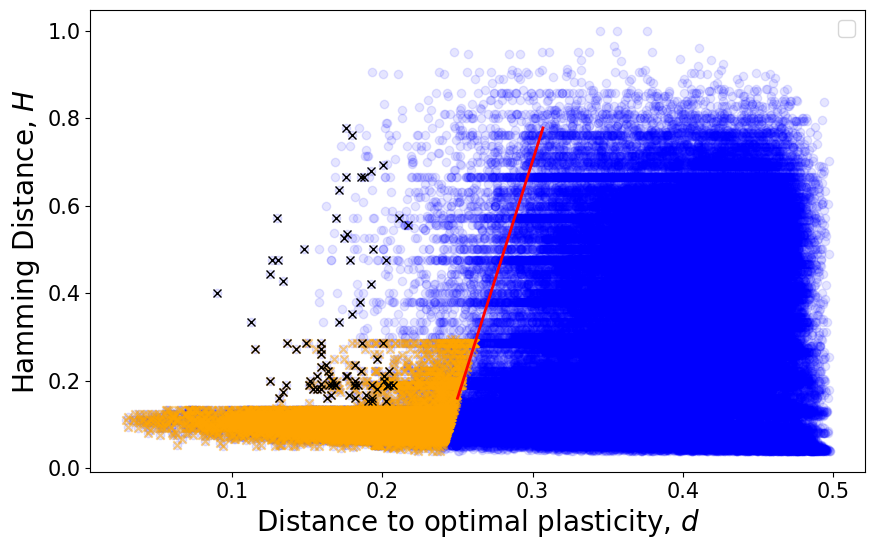

In [24]:
from matplotlib import pyplot as plt 
import numpy as np

diagonal_distances = {}
for x, y,key1,key2 in zip(fRNAprob1.values(), fRNAprob2.values(), fRNAprob1.keys(), fRNAprob2.keys()):
    if key1 == key2:
        distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)/np.sqrt(2)
        diagonal_distances[key1] = distance

selected_names = []
selected_hamming_values =[]
selected_min_distances = []
for name in fRNAhammingdistance.keys():
    if '.' * len(name[1]) not in fRNAfolds[name]:
        selected_names.append(name)
        selected_hamming_values.append(fRNAhammingdistance[name])
        selected_min_distances.append(diagonal_distances[name])
selected_names = np.array(selected_names)
selected_hamming_values = np.array(selected_hamming_values)
selected_min_distances = np.array(selected_min_distances)
point0 = (0.30688980382826875,0.7777777777777778) #('FR481122||Fly small RNA', 'TCGAATCCGAAGATTGCA') 0.30688980382826875 0.7777777777777778
point1 =  (0.25,0.16)

m= (point1[1] - point0[1]) / (point1[0] - point0[0])
b = point1[1] - m * point1[0]

# Define a function to determine if a point is to the left of the line
def is_left_of_line(x, y, m, b):
    return y > m * x + b
def is_hamming_greater_than_small(h,h0=0.3):
    return h < h0

left_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m, b) & is_hamming_greater_than_small(selected_hamming_values)
# Filter points that are to the left of the second line




left_names_tot_bottom= selected_names[left_mask]
left_min_distances = selected_min_distances[left_mask]
left_hamming_values = selected_hamming_values[left_mask]


# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(selected_min_distances, selected_hamming_values, c='blue', marker='o', alpha=0.1)
plt.scatter(left_min_distances, left_hamming_values, c='orange', marker='x', alpha=0.5)
#plt.scatter(left_min_distances, left_hamming_values, c='purple', marker='x', alpha=0.5, label='Left of Line')
plt.plot([point0[0], point1[0]], [point0[1], point1[1]], color='red', linestyle='-', linewidth=2)
for name in nameandrankdist_hammingandprobs_pvals_left.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')
for name in nameandrankdist_hammingandprobs_pvals_left_minus.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')
#for name in nameandrankdist_hammingandprobs_pvals_left_minus_bottom.keys():
#    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')

# Add labels and title
plt.ylabel(r'Hamming Distance, $H$', fontsize=20)
plt.xlabel(r'Distance to optimal plasticity, $d$', fontsize=20)
#plt.title('Selected fRNA sequences for analysis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
plt.legend(fontsize=15)
# Show the plot
plt.show()

In [25]:
left_names_minus_bottom = []
for i in left_names_tot_bottom:
    if i in left_names or i in left_names_tot: continue
    else: left_names_minus_bottom.append(i)



In [37]:
len(left_names_minus_bottom)

15617

In [39]:
left_names_minus_bottom[1443]

array(['FR057564||Putative conserved noncoding region (EvoFold)',
       'TGAATTAATTCTGCTTTAATTCA'], dtype='<U3484')

In [40]:
import glob
import pandas as pd
import re
import numpy as np
from scipy.stats import norm
from collections import defaultdict
import pickle
# Path to the data folder
data_folder = '../data/'

# Pattern to match the files
file_pattern = data_folder + 'site_scanning_probs_pval_seq_left_minus_bottom*_ssize10000.pkl'

# List to store p-values from all files
nameandrankdist_hammingandprobs_pvals_left_minus_bottom = defaultdict(dict)


files = glob.glob(file_pattern)
#with open(f"../data/selected_names_left_minus_bottom.pkl","rb") as f:
#    left_names = pickle.load(f)
left_names = left_names_minus_bottom
print(len(left_names))
# Loop through each file and extract probs2
for file in files:
    match = re.search(r'site_scanning_probs_pval_seq_left_minus_bottom(\d+)_ssize10000', file)
    if match:
        seq_number = int(match.group(1))
        # Read the file into a DataFrame
        with open(file, 'rb') as f:
            data = pickle.load(f)
        
        # Extract probs2 and append to the list
        probs2 = list(data['probs2'])
        observed_value = fRNAprob2[tuple(left_names[seq_number])]  # Replace with your specific value
        
        mean = np.mean(probs2)
        std_dev = np.std(probs2)

        # Compute the z-score for the observed value
        z_score = (observed_value - mean) / std_dev

        # One-tailed p-value (upper-tail)
        p_value_upper = 1 - norm.cdf(z_score)
        if p_value_upper < 0.05:
            print(seq_number, tuple(left_names[seq_number]), p_value_upper)
            nameandrankdist_hammingandprobs_pvals_left_minus_bottom[tuple(left_names[seq_number])][(fRNAhammingdistance[tuple(left_names[seq_number])],fRNAprob1[tuple(left_names[seq_number])],fRNAprob2[tuple(left_names[seq_number])])] = p_value_upper

15617
1443 ('FR057564||Putative conserved noncoding region (EvoFold)', 'TGAATTAATTCTGCTTTAATTCA') 0.014730486160312029


858 ('FR035143||Putative conserved noncoding region (EvoFold)', 'TGACATCTGAAAATGGGGATGTCA') 0.0012589532359418287
932 ('FR037958||Putative conserved noncoding region (EvoFold)', 'TGGATTGTATTTATAATCCA') 0.027002991522885766
0 ('FR000056||Putative conserved noncoding region (EvoFold)', 'AGATGGATGAGTTGGATCCATCT') 0.040388325598329056
810 ('FR032901||Putative conserved noncoding region (EvoFold)', 'ACTTCCTGAGGAAGGAAGT') 0.034114629406581054
588 ('FR024149||Putative conserved noncoding region (EvoFold)', 'TTCTGCCCACGCAGAG') 0.02006697656732226
951 ('FR038774||Putative conserved noncoding region (EvoFold)', 'TCCATTCAGTGAATGGA') 0.012550901484709387
464 ('FR019424||Putative conserved noncoding region (EvoFold)', 'AGCTGGACTCAATCCAGTT') 0.01993141518082775
7 ('FR000245|DQ721482|Piwi-interacting RNA (piRNA)', 'GCATGAAATACAAGGTCAGAAGAGACCTAGG') 0.016052331097298977
1348 ('FR054114||Putative conserved noncoding region (EvoFold)', 'TTTTATAAGATTTGGAAGAGACAAATCTTGTGAAA') 0.028594687893501614
151 ('FR

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


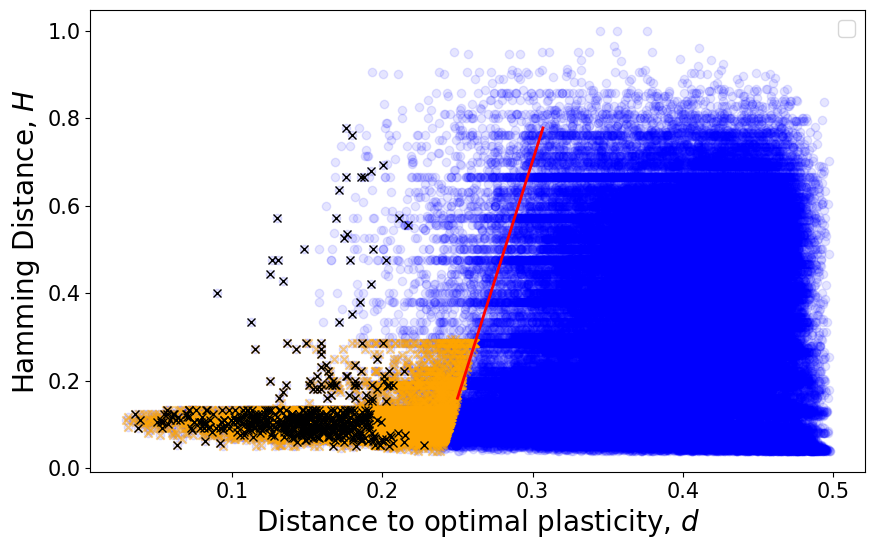

In [41]:
from matplotlib import pyplot as plt 
import numpy as np

diagonal_distances = {}
for x, y,key1,key2 in zip(fRNAprob1.values(), fRNAprob2.values(), fRNAprob1.keys(), fRNAprob2.keys()):
    if key1 == key2:
        distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)/np.sqrt(2)
        diagonal_distances[key1] = distance

selected_names = []
selected_hamming_values =[]
selected_min_distances = []
for name in fRNAhammingdistance.keys():
    if '.' * len(name[1]) not in fRNAfolds[name]:
        selected_names.append(name)
        selected_hamming_values.append(fRNAhammingdistance[name])
        selected_min_distances.append(diagonal_distances[name])
selected_names = np.array(selected_names)
selected_hamming_values = np.array(selected_hamming_values)
selected_min_distances = np.array(selected_min_distances)
point0 = (0.30688980382826875,0.7777777777777778) #('FR481122||Fly small RNA', 'TCGAATCCGAAGATTGCA') 0.30688980382826875 0.7777777777777778
point1 =  (0.25,0.16)

m= (point1[1] - point0[1]) / (point1[0] - point0[0])
b = point1[1] - m * point1[0]

# Define a function to determine if a point is to the left of the line
def is_left_of_line(x, y, m, b):
    return y > m * x + b
def is_hamming_greater_than_small(h,h0=0.3):
    return h < h0

left_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m, b) & is_hamming_greater_than_small(selected_hamming_values)
# Filter points that are to the left of the second line




left_names_tot_bottom= selected_names[left_mask]
left_min_distances = selected_min_distances[left_mask]
left_hamming_values = selected_hamming_values[left_mask]


# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(selected_min_distances, selected_hamming_values, c='blue', marker='o', alpha=0.1)
plt.scatter(left_min_distances, left_hamming_values, c='orange', marker='x', alpha=0.5)
#plt.scatter(left_min_distances, left_hamming_values, c='purple', marker='x', alpha=0.5, label='Left of Line')
plt.plot([point0[0], point1[0]], [point0[1], point1[1]], color='red', linestyle='-', linewidth=2)
for name in nameandrankdist_hammingandprobs_pvals_left.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')
for name in nameandrankdist_hammingandprobs_pvals_left_minus.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')
for name in nameandrankdist_hammingandprobs_pvals_left_minus_bottom.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')

# Add labels and title
plt.ylabel(r'Hamming Distance, $H$', fontsize=20)
plt.xlabel(r'Distance to optimal plasticity, $d$', fontsize=20)
#plt.title('Selected fRNA sequences for analysis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
plt.legend(fontsize=15)
# Show the plot
plt.show()

# fRNA significant length

In [42]:
merged_dict = {**nameandrankdist_hammingandprobs_pvals_left, **nameandrankdist_hammingandprobs_pvals_left_minus,**nameandrankdist_hammingandprobs_pvals_left_minus_bottom}

In [43]:
len (merged_dict)

558

In [44]:
with open('../data/merged_dict.pkl', 'wb') as f:
    pickle.dump(merged_dict, f)

In [1]:
import pickle
with open('../data/merged_dict.pkl', 'rb') as f:
    merged_dict = pickle.load(f)

In [28]:
sorted_merged_dict = dict(sorted(merged_dict.items(), key=lambda item: list(item[1].values())[0]))


In [29]:
sorted_merged_dict

{('FR001310|D16617|Hepatitis C stem-loop IV',
  'CTTTGCCTACTCCTACTCACCGTAGGGGTAGGCGTTT'): {(0.2222222222222222,
   0.43645017760912713,
   0.43645017760912713): 1.0672731692973336e-05},
 ('FR026182||Putative conserved noncoding region (EvoFold)',
  'TGGTTCTGTCTTGAACCA'): {(0.625,
   0.4927602949545851,
   0.4458679529973449): 7.243888095720408e-05},
 ('FR040058||Putative conserved noncoding region (EvoFold)',
  'TGGCGCCTGGTCACAGGTGCCA'): {(0.7619047619047619,
   0.49399286305325024,
   0.4469832267332937): 7.580966282905166e-05},
 ('FR033841||Putative conserved noncoding region (EvoFold)',
  'TGCTGGGGCGCCAGCA'): {(0.19047619047619047,
   0.49732415304663524,
   0.44999750256963805): 9.135799502535402e-05},
 ('FR025156||Putative conserved noncoding region (EvoFold)',
  'TGATTACTAGATGTAATCA'): {(0.5789473684210527,
   0.4750829036555583,
   0.4298727878967216): 0.00016868346226595055},
 ('FR031742||Putative conserved noncoding region (EvoFold)',
  'TGAAGGCAGGCACCACGCAAAGGTGCCTGTTTTCA'): 

In [30]:
fRNAfolds[('FR001310|D16617|Hepatitis C stem-loop IV',
  'CTTTGCCTACTCCTACTCACCGTAGGGGTAGGCGTTT')]

['...(((((((((((((.....)))))))))))))...',
 '....((((((((((((.....))))))))))))....']

In [33]:
from functionalRNA import *
output,out = suboptfolding('CTTTGCCTACTCCTACTCACCGTAGGGGTAGGCGTTT')
print(output)

[('...(((((((((((((.....)))))))))))))...', -22.0, 0.43645017760912713), ('....((((((((((((.....))))))))))))....', -22.0, 0.43645017760912713), ('..(.((((((((((((.....)))))))))))))...', -18.2, 0.00976372734987673), ('...((((((((((((.......))))))))))))...', -18.2, 0.00976372734987673), ('....(((((((((((.......)))))))))))....', -18.2, 0.00976372734987673), ('.....(((((((((((.....))))))))))).....', -18.2, 0.00976372734987673), ('(...((((((((((((.....)))))))))))))...', -17.9, 0.007233147122557098), ('...(((((((.(((((.....))))).)))))))...', -17.9, 0.007233147122557098), ('....((((((.(((((.....))))).))))))....', -17.9, 0.007233147122557098), ('.(..((((((((((((.....)))))))))))))...', -17.5, 0.004848523512175034), ('...((((.((((((((.....)))))))).))))...', -17.4, 0.004387125496043093), ('...((((((((((.((.....)).))))))))))...', -17.4, 0.004387125496043093), ('....(((.((((((((.....)))))))).)))....', -17.4, 0.004387125496043093), ('....(((((((((.((.....)).)))))))))....', -17.4, 0.004387125496043093

In [39]:
values_list = [list(inner_dict.values())[0] for inner_dict in merged_dict.values()]


In [40]:
values_list

[0.016133759043367557,
 0.015760617870453797,
 0.008194209769770255,
 0.019506409763084487,
 0.04598591664532048,
 0.02231064216437051,
 0.026898799451784194,
 0.01801179231016159,
 0.031105406237797117,
 0.009943055800997191,
 0.010812287512418584,
 0.028536853903184167,
 0.04760926337461968,
 0.04357384506470785,
 0.014001111164685387,
 0.03806373870607693,
 0.03962325609309203,
 0.01582323657237672,
 0.009939238081922763,
 0.002660494011209158,
 0.00791486754570847,
 0.022922741816410186,
 0.02712034103926564,
 0.025621315906506625,
 0.026164516408806127,
 0.0007810370716745396,
 0.04301023345768795,
 0.01729366153062728,
 0.026368636283864766,
 0.0017350956829191855,
 0.043750165625218496,
 0.007080898894712417,
 0.004896981755479368,
 0.027001209988387953,
 0.006532816783252016,
 0.00846125325332292,
 0.03669213786220138,
 0.049036400556988546,
 0.02791640365784831,
 0.03555157771168149,
 0.049596973545311895,
 0.028053601598315714,
 0.02789355245181857,
 0.03686749986524396,
 0.0

# Statistical error

In [45]:
import numpy as np

def false_discovery_control(ps, *, axis=0, method='bh'):
    """
    Control the false discovery rate (FDR) using the specified method.

    Parameters:
    ps (array-like): Array of p-values.
    axis (int): Axis along which to apply the FDR control.
    method (str): Method to use for FDR control. Default is 'bh' (Benjamini-Hochberg).

    Returns:
    array-like: Array of adjusted p-values.
    """
    ps = np.asarray(ps)
    if method == 'bh':
        # Benjamini-Hochberg procedure
        shape = ps.shape
        ps = np.sort(ps, axis=axis)
        n = ps.shape[axis]
        i = np.arange(1, n + 1)
        adjusted_ps = ps * n / i
        adjusted_ps = np.minimum.accumulate(adjusted_ps[::-1], axis=axis)[::-1]
        print(adjusted_ps)
        adjusted_ps = np.minimum(adjusted_ps, 1)
        return adjusted_ps.reshape(shape)
    else:
        raise ValueError(f"Unknown method: {method}")

# Example usage
p_values = values_list
adjusted_p_values = false_discovery_control(p_values, method='bh')
print(adjusted_p_values)

[0.00405564 0.00764236 0.00764236 0.00764236 0.00764236 0.00764236
 0.00764236 0.00764236 0.00764236 0.00764236 0.00764236 0.00764236
 0.00764236 0.00764236 0.00764236 0.00764236 0.00764236 0.00764236
 0.00815073 0.00815073 0.00815073 0.00815073 0.00930815 0.00930815
 0.00930815 0.00949668 0.01099237 0.01195731 0.01202892 0.01202892
 0.01202892 0.01202892 0.01208095 0.01252989 0.01280201 0.01280201
 0.01280201 0.01280201 0.01318429 0.01318429 0.01562024 0.01569848
 0.01631496 0.01631496 0.01720242 0.01720242 0.01725356 0.01725356
 0.01849374 0.01914337 0.01982329 0.02016055 0.02164586 0.02164586
 0.02263925 0.02263925 0.02263925 0.02263925 0.02263925 0.02263925
 0.02325501 0.02354331 0.02357236 0.02466031 0.02498628 0.02512287
 0.02658362 0.02658362 0.02658362 0.02658362 0.02741489 0.0279776
 0.0279776  0.02823964 0.02860624 0.02865315 0.02883312 0.02883312
 0.029698   0.03029982 0.03029982 0.03029982 0.03029982 0.03055955
 0.03065069 0.03065069 0.03065069 0.03065069 0.03341833 0.03341

# Length of RNA analysis

In [45]:
siglengthRNA = []
sighammingRNA = []
sigdistRNA = []
signame = []
for name in merged_dict.keys():
    siglengthRNA.append(len(name[1]))
    sighammingRNA.append(fRNAhammingdistance[name])
    sigdistRNA.append(diagonal_distances[name])
    signame.append(name)

In [46]:
len(signame)

558

In [47]:
lengthRNA = []
for name in selected_names:
    lengthRNA.append(len(name[1]))


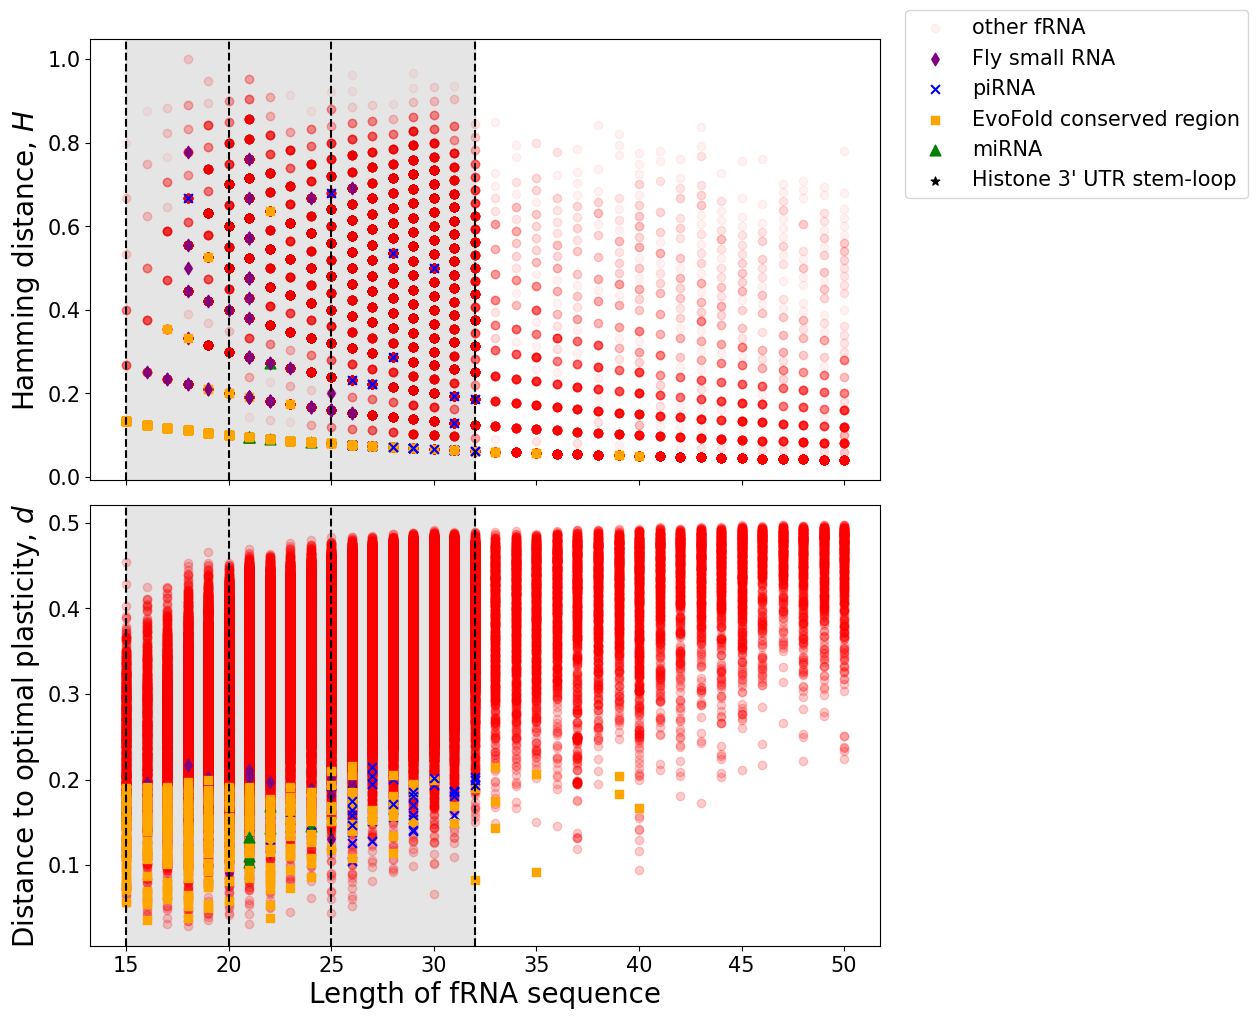

In [ ]:
import matplotlib.pyplot as plt

# Sample data for demonstration

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 10),sharex=True)
# Add grey backgrounds

ax1.axvline(x=15, color='black', linestyle='--')
ax1.axvline(x=20, color='black', linestyle='--')
ax1.axvline(x=25, color='black', linestyle='--')
ax1.axvline(x=32, color='black', linestyle='--')


ax2.axvline(x=15, color='black', linestyle='--')
ax2.axvline(x=20, color='black', linestyle='--')
ax2.axvline(x=25, color='black', linestyle='--')
ax2.axvline(x=32, color='black', linestyle='--')
"""
ax1.axvspan(15, 20, color='grey', alpha=0.3)
ax1.axvspan(20, 25, color='grey', alpha=0.7)
ax1.axvspan(25, 32, color='grey', alpha=0.9)

ax2.axvspan(15, 20, color='grey', alpha=0.3)
ax2.axvspan(20, 25, color='grey', alpha=0.7)
ax2.axvspan(25, 32, color='grey', alpha=0.9)
"""
ax1.axvspan(15, 32, color='grey', alpha=0.2)
ax2.axvspan(15, 32, color='grey', alpha=0.2)



# First subplot
otherlengthRNA = []
otherhammingRNA = []
otherdistRNA = []
for i in range(0,len(selected_names)):
    name =tuple(selected_names[i])
    if name not in signame:
        otherlengthRNA.append(len(name[1]))
        otherhammingRNA.append(fRNAhammingdistance[name])
        otherdistRNA.append(diagonal_distances[name])

ax1.scatter(otherlengthRNA, otherhammingRNA, c='red', marker='o', alpha=0.05, label='other fRNA')
#ax1.scatter(siglengthRNA, sighammingRNA, c='black', marker='o', alpha=1.0)
#ax1.scatter(len(name[1]), fRNAhammingdistance[name], c='blue', marker='o', alpha=1.0, label='(miRNA) miR-27a-3p')
ax2.scatter(otherlengthRNA, otherdistRNA, c='red', marker='o', alpha=0.2)
#ax2.scatter(siglengthRNA, sigdistRNA, c='black', marker='o', alpha=1.0)

#ax1.set_xlabel('Length of fRNA sequence', fontsize=20)
ax1.set_ylabel('Hamming distance, $H$', fontsize=20)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)

ax2.set_xlabel('Length of fRNA sequence', fontsize=20)
ax2.set_ylabel('Distance to optimal plasticity, $d$', fontsize=20)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

# Second subplot
#name = ('FR258706||mature micro RNA (miRNA) miR-27a-3p', 'TTCACAGTGGCTAAGTTCCGCC')

for name in signame:
 
    
    if 'EvoFold' in name[0]:
        ax1.scatter(len(name[1]), fRNAhammingdistance[name], c='orange', marker='s',s =40, alpha=1.0, label='EvoFold conserved region')
        ax2.scatter(len(name[1]), diagonal_distances[name], c='orange', marker='s',s =40, alpha=1.0, label='EvoFold conserved region')
    if 'Fly small RNA' in name[0]:
        ax1.scatter(len(name[1]), fRNAhammingdistance[name], c='purple', marker='d',s =40, alpha=1.0, label='Fly small RNA')
        ax2.scatter(len(name[1]), diagonal_distances[name], c='purple', marker='d', s=40,alpha=1.0, label='Fly small RNA')
    if 'Histone' in name[0]:
        ax1.scatter(len(name[1]), fRNAhammingdistance[name], c='black', marker='*',s =40, alpha=1.0, label='Histone 3\' UTR stem-loop')
        ax2.scatter(len(name[1]), diagonal_distances[name], c='black', marker='*',s =40, alpha=1.0, label='Histone 3\' UTR stem-loop')
    if 'piRNA' in name[0]:
        ax1.scatter(len(name[1]), fRNAhammingdistance[name], c='blue', marker='x',s=40, alpha=1.0, label='piRNA')
        ax2.scatter(len(name[1]), diagonal_distances[name], c='blue', marker='x', s=40,alpha=1.0, label='piRNA')
    if 'miRNA' in name[0]:
        ax1.scatter(len(name[1]), fRNAhammingdistance[name], c='green', marker='^',s =60, alpha=1.0, label='miRNA')
        ax2.scatter(len(name[1]), diagonal_distances[name], c='green', marker='^',s =60, alpha=1.0, label='miRNA')

#ax2.scatter(len(name[1]), diagonal_distances[name], c='blue', marker='o', alpha=1.0, label='(miRNA) miR-27a-3p')

#ax2.legend(fontsize=15)
handles, labels = [], []
for ax in [ax1, ax2]:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in labels:
            handles.append(handle)
            labels.append(label)

fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.92), fontsize=15)
# Show the plot
plt.tight_layout()
plt.show()

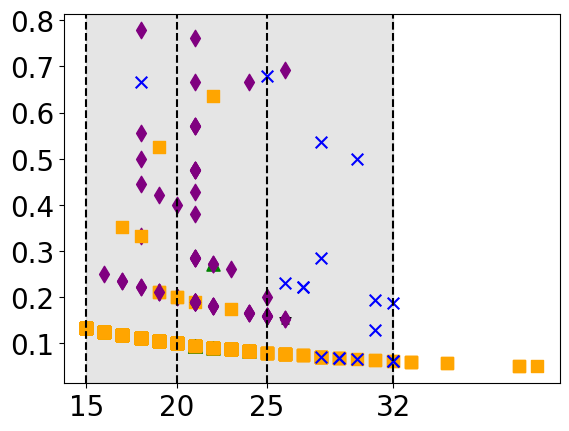

In [49]:
#plt.scatter(otherlengthRNA, otherhammingRNA, c='red', marker='o', alpha=0.1, label='other fRNA')
plt.axvline(x=15, color='black', linestyle='--')
plt.axvline(x=20, color='black', linestyle='--')
plt.axvline(x=25, color='black', linestyle='--')
plt.axvline(x=32, color='black', linestyle='--')
plt.xticks([15,20,25,32], fontsize=20)
plt.yticks(fontsize=20)
plt.axvspan(15, 32, color='grey', alpha=0.2)
for name in signame:
    if 'EvoFold' in name[0]:
        plt.scatter(len(name[1]), fRNAhammingdistance[name], c='orange', marker='s',s =70, alpha=1.0, label='EvoFold conserved region')
    if 'Fly small RNA' in name[0]:
        plt.scatter(len(name[1]), fRNAhammingdistance[name], c='purple', marker='d',s =70, alpha=1.0, label='Fly small RNA')
    if 'Histone' in name[0]:
        plt.scatter(len(name[1]), fRNAhammingdistance[name], c='black', marker='*',s =70, alpha=1.0, label='Histone 3\' UTR stem-loop')
    if 'piRNA' in name[0]:
        plt.scatter(len(name[1]), fRNAhammingdistance[name], c='blue', marker='x',s=70, alpha=1.0, label='piRNA')
    if 'miRNA' in name[0]:
        plt.scatter(len(name[1]), fRNAhammingdistance[name], c='green', marker='^',s =90, alpha=1.0, label='miRNA')


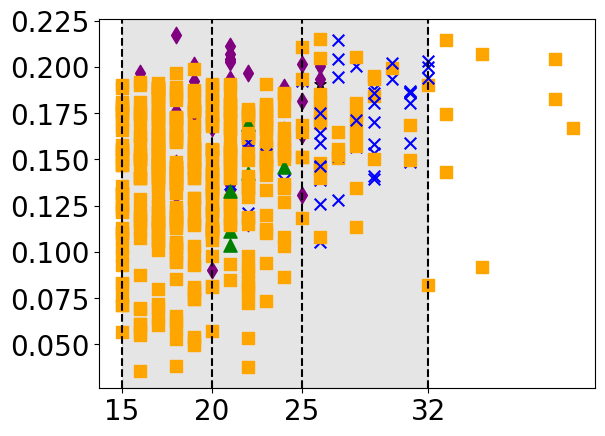

In [50]:
#plt.scatter(otherlengthRNA, otherhammingRNA, c='red', marker='o', alpha=0.1, label='other fRNA')
plt.axvline(x=15, color='black', linestyle='--')
plt.axvline(x=20, color='black', linestyle='--')
plt.axvline(x=25, color='black', linestyle='--')
plt.axvline(x=32, color='black', linestyle='--')
plt.xticks([15,20,25,32], fontsize=20)
plt.yticks(fontsize=20)
plt.axvspan(15, 32, color='grey', alpha=0.2)
for name in signame:
    if 'EvoFold' in name[0]:
        plt.scatter(len(name[1]), diagonal_distances[name], c='orange', marker='s',s =70, alpha=1.0, label='EvoFold conserved region')
    if 'Fly small RNA' in name[0]:
        plt.scatter(len(name[1]), diagonal_distances[name], c='purple', marker='d',s =70, alpha=1.0, label='Fly small RNA')
    if 'Histone' in name[0]:
        plt.scatter(len(name[1]), diagonal_distances[name], c='black', marker='*',s =70, alpha=1.0, label='Histone 3\' UTR stem-loop')
    if 'piRNA' in name[0]:
        plt.scatter(len(name[1]), diagonal_distances[name], c='blue', marker='x',s=70, alpha=1.0, label='piRNA')
    if 'miRNA' in name[0]:
        plt.scatter(len(name[1]), diagonal_distances[name], c='green', marker='^',s =90, alpha=1.0, label='miRNA')

In [93]:
for i,j in zip(siglengthRNA,signame):
    if i ==18:
        print(j)

('FR422481||Fly small RNA', 'AGTCAAACGGCAAAACGG')
('FR454945||Fly small RNA', 'GATGGTCTCATCGACGGT')
('FR132646|DQ703740|Piwi-interacting RNA (piRNA)', 'CTATCCAACCCAGATGGG')
('FR460884||Fly small RNA', 'GGCTTTCAGCCTGCCAGC')
('FR442942||Fly small RNA', 'CGGGAGGAGGAGATCCTA')
('FR287373||Putative conserved noncoding region (EvoFold)', 'CCTTCTGGGTGAAGGAGG')


In [79]:
print(fRNAfolds[('FR258706||mature micro RNA (miRNA) miR-27a-3p', 'TTCACAGTGGCTAAGTTCCGCC')])
print(fRNAprob1[('FR258706||mature micro RNA (miRNA) miR-27a-3p', 'TTCACAGTGGCTAAGTTCCGCC')])
print(fRNAhammingdistance[('FR258706||mature micro RNA (miRNA) miR-27a-3p', 'TTCACAGTGGCTAAGTTCCGCC')])

['......((((.......)))).', '........(((........)))']
0.3761745551105658
0.2727272727272727


# compare MFE and subopt

quantify how often a subopt of fRNA in MFE of another fRNA,

In [51]:
from collections import Counter
from collections import defaultdict

mfe_elements_tot = [tup[0] for tup in fRNAfolds.values() if '.' * len(tup[0]) not in tup]
subopt_elements_tot = [tup[1] for tup in fRNAfolds.values() if '.' * len(tup[1]) not in tup]
names_elements_tot = [name for name in fRNAfolds.keys() if '.' * len(fRNAfolds[name][0]) not in fRNAfolds[name]]

names_merged = [name for name in merged_dict.keys()]
mfe_merged = [fRNAfolds[name][0] for name in names_merged]
subopt_merged = [fRNAfolds[name][1] for name in names_merged]


names_elements_tot_minus_merged = [name for name in names_elements_tot if name not in names_merged]
mfe_elements_tot_minus_merged = [fRNAfolds[name][0] for name in names_elements_tot_minus_merged]
subopt_elements_tot_minus_merged = [fRNAfolds[name][1] for name in names_elements_tot_minus_merged]
count_mfe_elements_tot_minus_merged = Counter(mfe_elements_tot_minus_merged)
count_subopt_elements_tot_minus_merged = Counter(subopt_elements_tot_minus_merged)

count_mfe_elements_merged = Counter(mfe_merged)
count_subopt_elements_merged = Counter(subopt_merged)

Find complementary sequences: fRNAs that have unlikely plasticity, do these share structural motifs? why would they? how can I measure this?

count how many times an mfe appears as suboptimal, and how many times a suboptimal appears as mfe

In [52]:
from collections import Counter
from collections import defaultdict
count_subopt_as_mfe_in_tot_minus_merged= defaultdict(float)
for i in range(len(subopt_elements_tot_minus_merged)):
    subopt = subopt_elements_tot_minus_merged[i]
    count_subopt_as_mfe_in_tot_minus_merged[subopt] = count_mfe_elements_tot_minus_merged[subopt]

In [53]:
from collections import Counter
from collections import defaultdict
count_subopt_as_mfe_merged= defaultdict(float)
for i in range(len(subopt_merged)):
    subopt = subopt_merged[i]
    count_subopt_as_mfe_merged[subopt] = count_mfe_elements_merged[subopt]

In [54]:
from collections import Counter
from collections import defaultdict
count_mfe_as_subopt_in_tot_minus_merged= defaultdict(float)
for i in range(len(mfe_elements_tot_minus_merged)):
    mfe = mfe_elements_tot_minus_merged[i]
    count_mfe_as_subopt_in_tot_minus_merged[mfe] = count_subopt_elements_tot_minus_merged[mfe]

In [55]:
from collections import Counter
from collections import defaultdict
count_mfe_as_subopt_merged= defaultdict(float)
for i in range(len(mfe_merged)):
    mfe = mfe_merged[i]
    count_mfe_as_subopt_merged[mfe] = count_subopt_elements_merged[mfe]

In [56]:
count_subopt_as_mfe_merged = dict(sorted(count_subopt_as_mfe_merged.items(), key=lambda item: item[1], reverse=True))
count_mfe_as_subopt_merged = dict(sorted(count_mfe_as_subopt_merged.items(), key=lambda item: item[1], reverse=True))
count_subopt_as_mfe_in_tot_minus_merged = dict(sorted(count_subopt_as_mfe_in_tot_minus_merged.items(), key=lambda item: item[1], reverse=True))
count_mfe_as_subopt_in_tot_minus_merged = dict(sorted(count_mfe_as_subopt_in_tot_minus_merged.items(), key=lambda item: item[1], reverse=True))

In [57]:
from collections import defaultdict

samelength_count_subopt_as_mfe_merged = defaultdict(dict)

for structure, val in count_subopt_as_mfe_merged.items():
    length = len(structure)
    if val!=0:
        samelength_count_subopt_as_mfe_merged[length].update({structure:val})

In [58]:
samelength_count_mfe_as_subopt_merged = defaultdict(dict)

for structure, val in count_mfe_as_subopt_merged.items():
    length = len(structure)
    if val!=0:
        samelength_count_mfe_as_subopt_merged[length].update({structure:val})

In [59]:
samelength_count_mfe_as_subopt_merged

defaultdict(dict,
            {18: {'.((((((....)))))).': 23,
              '(((((((....)))))))': 15,
              '.(((((......))))).': 12,
              '((((((......))))))': 3},
             16: {'.(((((....))))).': 21,
              '((((((....))))))': 9,
              '(((((......)))))': 2},
             15: {'.(((((...))))).': 21,
              '((((((...))))))': 13,
              '(((((.....)))))': 5},
             17: {'.((((((...)))))).': 19,
              '(((((((...)))))))': 16,
              '((((((.....))))))': 15,
              '.(((((.....))))).': 14},
             20: {'.(((((((....))))))).': 15,
              '((((((((....))))))))': 11,
              '(((((((......)))))))': 8,
              '.((((((......)))))).': 5,
              '.(((((........))))).': 3,
              '((((((........))))))': 1},
             19: {'.((((((.....)))))).': 14,
              '(((((((.....)))))))': 12,
              '.(((((((...))))))).': 6,
              '((((((((...))))))))': 4,
      

In [60]:
samelength_count_subopt_as_mfe_merged

defaultdict(dict,
            {15: {'((((((...))))))': 26,
              '(((((.....)))))': 8,
              '.(((((...))))).': 6},
             17: {'(((((((...)))))))': 26,
              '((((((.....))))))': 17,
              '.((((((...)))))).': 13,
              '.(((((.....))))).': 8},
             18: {'(((((((....)))))))': 24,
              '.((((((....)))))).': 14,
              '((((((......))))))': 14,
              '.(((((......))))).': 2},
             16: {'((((((....))))))': 23,
              '.(((((....))))).': 9,
              '(((((......)))))': 1},
             19: {'(((((((.....)))))))': 16,
              '.((((((.....)))))).': 9,
              '((((((((...))))))))': 9,
              '.(((((((...))))))).': 2,
              '((.((((.....)))).))': 1,
              '...((((.....))))...': 1},
             20: {'((((((((....))))))))': 15,
              '.(((((((....))))))).': 10,
              '.((((((......)))))).': 8,
              '(((((((......)))))))': 6,
           

In [61]:
mfe_to_subopt_merged = defaultdict(tuple)
subopt_to_mfe_merged = defaultdict(tuple)
mfe_to_subopt_merged_mfename = []
mfe_to_subopt_merged_suboptname = []
mfe_to_subopt_merged_structure = []
for name_mfe_merged in list(merged_dict.keys()):
    for suboptimal, suboptimalname in zip(subopt_merged, names_merged):
        if fRNAfolds[name_mfe_merged][0] == suboptimal:
            #print(name_mfe_merged,':',fRNAfolds[name_mfe_merged],'and', suboptimalname,':',fRNAfolds[suboptimalname])
            mfe_to_subopt_merged_mfename.append(name_mfe_merged)
            mfe_to_subopt_merged_suboptname.append(suboptimalname)
            mfe_to_subopt_merged_structure.append(suboptimal)
            
subopt_to_mfe_merged_suboptname = []
subopt_to_mfe_merged_mfename = []
subopt_to_mfe_merged_structure = []

for name_subopt_merged in list(merged_dict.keys()):
    for mfe, mfename in zip(mfe_merged, names_merged):
        if fRNAfolds[name_subopt_merged][1] == mfe:
            #print(name_subopt_merged,':',fRNAfolds[name_subopt_merged],'and', mfename,':',fRNAfolds[mfename])
            subopt_to_mfe_merged_suboptname.append(name_subopt_merged)
            subopt_to_mfe_merged_mfename.append(mfename)
            subopt_to_mfe_merged_structure.append(mfe)

In [64]:
from collections import defaultdict

complementaryfRNAs = []
unique_tuples = set()

for i in range(len(mfe_to_subopt_merged_mfename)):
    name_mfe = mfe_to_subopt_merged_mfename[i]
    suboptname = mfe_to_subopt_merged_suboptname[i]
    for j in range(len(subopt_to_mfe_merged_suboptname)):
        name_subopt = subopt_to_mfe_merged_suboptname[j]
        mfename = subopt_to_mfe_merged_mfename[j]
        if name_mfe == name_subopt and suboptname == mfename:
            print(name_mfe, suboptname)
            print(fRNAfolds[name_mfe], 'and', fRNAfolds[suboptname])
            normalized_tuple = tuple(sorted((name_mfe, suboptname)))
            if normalized_tuple not in unique_tuples:
                unique_tuples.add(normalized_tuple)
                complementaryfRNAs.append(normalized_tuple)


('FR050025||Putative conserved noncoding region (EvoFold)', 'GTACCTGTGAGTTAGGAAC') ('FR463621||Fly small RNA', 'GTCCATCGCCCAGGTGTAC')
['...((((.....))))...', '((.((((.....)))).))'] and ['((.((((.....)))).))', '...((((.....))))...']
('FR463621||Fly small RNA', 'GTCCATCGCCCAGGTGTAC') ('FR050025||Putative conserved noncoding region (EvoFold)', 'GTACCTGTGAGTTAGGAAC')
['((.((((.....)))).))', '...((((.....))))...'] and ['...((((.....))))...', '((.((((.....)))).))']
('FR057564||Putative conserved noncoding region (EvoFold)', 'TGAATTAATTCTGCTTTAATTCA') ('FR017227||Putative conserved noncoding region (EvoFold)', 'TTAATTGCAACATGAGTAATTAA')
['((((((((.......))))))))', '.(((((((.......))))))).'] and ['.(((((((.......))))))).', '((((((((.......))))))))']
('FR035143||Putative conserved noncoding region (EvoFold)', 'TGACATCTGAAAATGGGGATGTCA') ('FR027690||Putative conserved noncoding region (EvoFold)', 'TTTGGGTTTTTTGTTTGACCCAAA')
['((((((((........))))))))', '.(((((((........))))))).'] and ['.(((((((.

In [65]:
len(complementaryfRNAs)

1496

In [66]:
complementaryfRNAs

[(('FR050025||Putative conserved noncoding region (EvoFold)',
   'GTACCTGTGAGTTAGGAAC'),
  ('FR463621||Fly small RNA', 'GTCCATCGCCCAGGTGTAC')),
 (('FR017227||Putative conserved noncoding region (EvoFold)',
   'TTAATTGCAACATGAGTAATTAA'),
  ('FR057564||Putative conserved noncoding region (EvoFold)',
   'TGAATTAATTCTGCTTTAATTCA')),
 (('FR027690||Putative conserved noncoding region (EvoFold)',
   'TTTGGGTTTTTTGTTTGACCCAAA'),
  ('FR035143||Putative conserved noncoding region (EvoFold)',
   'TGACATCTGAAAATGGGGATGTCA')),
 (('FR014962||Putative conserved noncoding region (EvoFold)',
   'TTCATAAAGGAAAAGATTTATGAA'),
  ('FR035143||Putative conserved noncoding region (EvoFold)',
   'TGACATCTGAAAATGGGGATGTCA')),
 (('FR037958||Putative conserved noncoding region (EvoFold)',
   'TGGATTGTATTTATAATCCA'),
  ('FR039406||Putative conserved noncoding region (EvoFold)',
   'TTTGTTCTGAGGAGAATAAA')),
 (('FR037958||Putative conserved noncoding region (EvoFold)',
   'TGGATTGTATTTATAATCCA'),
  ('FR045488||Putati

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


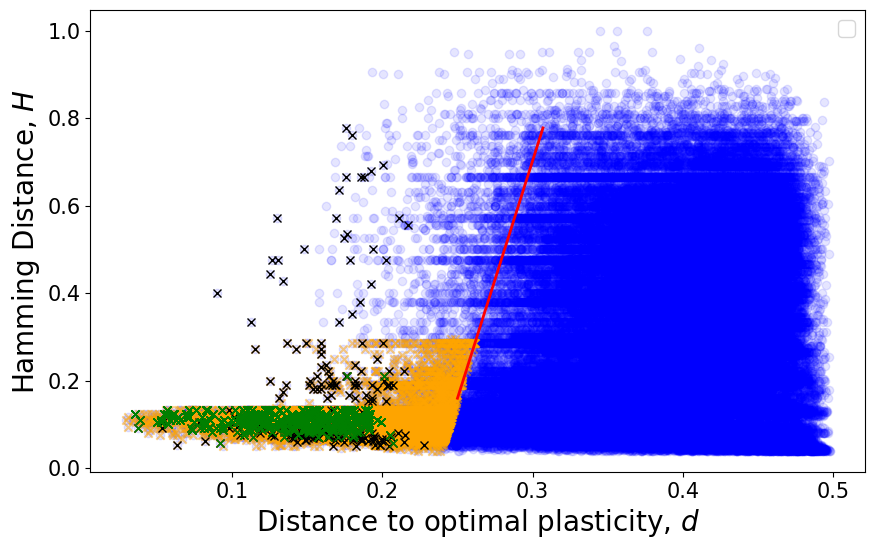

In [67]:
from matplotlib import pyplot as plt 
import numpy as np

diagonal_distances = {}
for x, y,key1,key2 in zip(fRNAprob1.values(), fRNAprob2.values(), fRNAprob1.keys(), fRNAprob2.keys()):
    if key1 == key2:
        distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)/np.sqrt(2)
        diagonal_distances[key1] = distance

selected_names = []
selected_hamming_values =[]
selected_min_distances = []
for name in fRNAhammingdistance.keys():
    if '.' * len(name[1]) not in fRNAfolds[name]:
        selected_names.append(name)
        selected_hamming_values.append(fRNAhammingdistance[name])
        selected_min_distances.append(diagonal_distances[name])
selected_names = np.array(selected_names)
selected_hamming_values = np.array(selected_hamming_values)
selected_min_distances = np.array(selected_min_distances)
point0 = (0.30688980382826875,0.7777777777777778) #('FR481122||Fly small RNA', 'TCGAATCCGAAGATTGCA') 0.30688980382826875 0.7777777777777778
point1 =  (0.25,0.16)

m= (point1[1] - point0[1]) / (point1[0] - point0[0])
b = point1[1] - m * point1[0]

# Define a function to determine if a point is to the left of the line
def is_left_of_line(x, y, m, b):
    return y > m * x + b
def is_hamming_greater_than_small(h,h0=0.3):
    return h < h0

left_mask = is_left_of_line(selected_min_distances, selected_hamming_values, m, b) & is_hamming_greater_than_small(selected_hamming_values)
# Filter points that are to the left of the second line




left_names_tot_bottom= selected_names[left_mask]
left_min_distances = selected_min_distances[left_mask]
left_hamming_values = selected_hamming_values[left_mask]


# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(selected_min_distances, selected_hamming_values, c='blue', marker='o', alpha=0.1)
plt.scatter(left_min_distances, left_hamming_values, c='orange', marker='x', alpha=0.5)
#plt.scatter(left_min_distances, left_hamming_values, c='purple', marker='x', alpha=0.5, label='Left of Line')
plt.plot([point0[0], point1[0]], [point0[1], point1[1]], color='red', linestyle='-', linewidth=2)
for name in nameandrankdist_hammingandprobs_pvals_left.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')
for name in nameandrankdist_hammingandprobs_pvals_left_minus.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')
for name in nameandrankdist_hammingandprobs_pvals_left_minus_bottom.keys():
    plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='black')
for names in complementaryfRNAs:
    for name in names:
        plt.plot(diagonal_distances[name], fRNAhammingdistance[name], 'x', color='green')

# Add labels and title
plt.ylabel(r'Hamming Distance, $H$', fontsize=20)
plt.xlabel(r'Distance to optimal plasticity, $d$', fontsize=20)
#plt.title('Selected fRNA sequences for analysis', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
plt.legend(fontsize=15)
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Sample data for demonstration

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 10),sharex=True)
# Add grey backgrounds

ax1.axvline(x=15, color='black', linestyle='--')
ax1.axvline(x=20, color='black', linestyle='--')
ax1.axvline(x=25, color='black', linestyle='--')
ax1.axvline(x=32, color='black', linestyle='--')


ax2.axvline(x=15, color='black', linestyle='--')
ax2.axvline(x=20, color='black', linestyle='--')
ax2.axvline(x=25, color='black', linestyle='--')
ax2.axvline(x=32, color='black', linestyle='--')
"""
ax1.axvspan(15, 20, color='grey', alpha=0.3)
ax1.axvspan(20, 25, color='grey', alpha=0.7)
ax1.axvspan(25, 32, color='grey', alpha=0.9)

ax2.axvspan(15, 20, color='grey', alpha=0.3)
ax2.axvspan(20, 25, color='grey', alpha=0.7)
ax2.axvspan(25, 32, color='grey', alpha=0.9)
"""
ax1.axvspan(15, 32, color='grey', alpha=0.2)
ax2.axvspan(15, 32, color='grey', alpha=0.2)



# First subplot
otherlengthRNA = []
otherhammingRNA = []
otherdistRNA = []
for i in range(0,len(selected_names)):
    name =tuple(selected_names[i])
    if name not in signame:
        otherlengthRNA.append(len(name[1]))
        otherhammingRNA.append(fRNAhammingdistance[name])
        otherdistRNA.append(diagonal_distances[name])

ax1.scatter(otherlengthRNA, otherhammingRNA, c='red', marker='o', alpha=0.05, label='other fRNA')
#ax1.scatter(siglengthRNA, sighammingRNA, c='black', marker='o', alpha=1.0)
#ax1.scatter(len(name[1]), fRNAhammingdistance[name], c='blue', marker='o', alpha=1.0, label='(miRNA) miR-27a-3p')
ax2.scatter(otherlengthRNA, otherdistRNA, c='red', marker='o', alpha=0.2)
#ax2.scatter(siglengthRNA, sigdistRNA, c='black', marker='o', alpha=1.0)

#ax1.set_xlabel('Length of fRNA sequence', fontsize=20)
ax1.set_ylabel('Hamming distance, $H$', fontsize=20)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)

ax2.set_xlabel('Length of fRNA sequence', fontsize=20)
ax2.set_ylabel('Distance to optimal plasticity, $d$', fontsize=20)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

# Second subplot
#name = ('FR258706||mature micro RNA (miRNA) miR-27a-3p', 'TTCACAGTGGCTAAGTTCCGCC')
for names in complementaryfRNAs:
    for name in names:
        ax1.scatter(len(name[1]), fRNAhammingdistance[name], c='black', marker='s',s =40, alpha=1.0, label='complementary')
        ax2.scatter(len(name[1]), diagonal_distances[name], c='black', marker='s',s =40, alpha=1.0, label='complementary')

"""
for name in signame:
 
    
    if 'EvoFold' in name[0]:
        ax1.scatter(len(name[1]), fRNAhammingdistance[name], c='orange', marker='s',s =40, alpha=1.0, label='EvoFold conserved region')
        ax2.scatter(len(name[1]), diagonal_distances[name], c='orange', marker='s',s =40, alpha=1.0, label='EvoFold conserved region')
    
    if 'Fly small RNA' in name[0]:
        ax1.scatter(len(name[1]), fRNAhammingdistance[name], c='purple', marker='d',s =40, alpha=1.0, label='Fly small RNA')
        ax2.scatter(len(name[1]), diagonal_distances[name], c='purple', marker='d', s=40,alpha=1.0, label='Fly small RNA')
    if 'Histone' in name[0]:
        ax1.scatter(len(name[1]), fRNAhammingdistance[name], c='black', marker='*',s =40, alpha=1.0, label='Histone 3\' UTR stem-loop')
        ax2.scatter(len(name[1]), diagonal_distances[name], c='black', marker='*',s =40, alpha=1.0, label='Histone 3\' UTR stem-loop')
    if 'piRNA' in name[0]:
        ax1.scatter(len(name[1]), fRNAhammingdistance[name], c='blue', marker='x',s=40, alpha=1.0, label='piRNA')
        ax2.scatter(len(name[1]), diagonal_distances[name], c='blue', marker='x', s=40,alpha=1.0, label='piRNA')
    if 'miRNA' in name[0]:
        ax1.scatter(len(name[1]), fRNAhammingdistance[name], c='green', marker='^',s =60, alpha=1.0, label='miRNA')
        ax2.scatter(len(name[1]), diagonal_distances[name], c='green', marker='^',s =60, alpha=1.0, label='miRNA')
"""
#ax2.scatter(len(name[1]), diagonal_distances[name], c='blue', marker='o', alpha=1.0, label='(miRNA) miR-27a-3p')

#ax2.legend(fontsize=15)
handles, labels = [], []
for ax in [ax1, ax2]:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in labels:
            handles.append(handle)
            labels.append(label)

fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.92), fontsize=15)
# Show the plot
plt.tight_layout()
plt.show()